# Model Explaining PPO (RNN):

---
## 1. Set-Up and Prep:

In [1]:
%%capture
import numpy as np
import pandas as pd
import torch
import shap

from stable_baselines3 import DDPG
from stable_baselines3.common.env_checker import check_env

from classes import ProsumerEnv, PPO_RNN

2023-07-19 08:33:52.882707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Defining some helper methods:

In [2]:
def print_violin_plot(index, shap_values, state_df):
    shap_values_np_arr = np.array(shap_values[index])

    shap.plots.violin(shap_values = shap_values_np_arr, features = state_df)

In [3]:
def print_scatter_plot(action_index, feature_index, shap_values, state_df):
    state_tensor_np_arr = np.array(state_df)
    shap_values_np_arr = np.array(shap_values[action_index])
    base_values_np_arr = np.array(explainer.expected_value)

    shap_obj = shap.Explanation(data = state_tensor_np_arr, values = shap_values_np_arr, base_values = base_values_np_arr, feature_names = columns)
    shap.plots.scatter(shap_obj[:, features_to_be_explained[feature_index]])

Import datasets:

In [4]:
columns = [
    'Demand (kWh)', 'PV Supply (kWh)', 
       
    'Import Price (EUR/kWh)', 'Air Temp. (°C)', 'Rel. Humidity (%)', 'Precip. Depth (mm)', 'Pressure (hPa)', 
    'Global Radiation (J/cm)', 'Sun Duration (min)', 'Wind Speed (m/sec)',
           
    'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 
    
    'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
    
    'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'
]

In [5]:
# Importing Dataframe for Res1:
df = pd.read_csv('./Dataframes/Res1.csv', 
                     names = columns, 
                     sep = ',')

df = df.drop(df.index[0], axis = 0)

for col in df:
    df[col] = pd.to_numeric(df[col])

In [6]:
# Importing Dataframe for Res4:
df_eval = pd.read_csv('./Dataframes/Res4.csv', 
                      names = columns, 
                      sep = ',')

df_eval = df_eval.drop(df_eval.index[0], axis = 0)

for col in df_eval:
    df_eval[col] = pd.to_numeric(df_eval[col])

Testing the environment:

In [7]:
env = ProsumerEnv.ProsumerEnv(df)
eval_env = ProsumerEnv.ProsumerEnv(df_eval)

check_env(env)
check_env(eval_env)

We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html


In [8]:
total_bill = 0
count = 0
rew_arr = []
    
done = False
obs, _ = env.reset()
    
while not done:
    # action = env.action_space.sample()
    action = [1, 1, 1, 0, 0]
        
    obs, reward, done, _, info = env.step(action)
    
    rew_arr.append(reward)
    
    if done:
        total_bill = info['electricity_bill']
            
    count += 1
     

average_reward = np.mean(np.array(rew_arr))
average_bill_per_hour = (total_bill / count) 
print('Total Electricity Bill: {}€ | Avg. Electricity Bill per Hour: {}€ | Avg. Reward: {}'.format(total_bill, average_bill_per_hour, average_reward))

Total Electricity Bill: 285.2533067774256€ | Avg. Electricity Bill per Hour: 0.04347710818128724€ | Avg. Reward: 4.956522891818713


In [9]:
total_bill = 0
count = 0
rew_arr = []
    
done = False
obs, _ = eval_env.reset()
    
while not done:
    # action = env.action_space.sample()
    action = [1, 1, 1, 0, 0]
        
    obs, reward, done, _, info = eval_env.step(action)
    
    rew_arr.append(reward)
    
    if done:
        total_bill = info['electricity_bill']
            
    count += 1
     

average_reward = np.mean(np.array(rew_arr))
average_bill_per_hour = (total_bill / count) 
print('Total Electricity Bill: {}€ | Avg. Electricity Bill per Hour: {}€ | Avg. Reward: {}'.format(total_bill, average_bill_per_hour, average_reward))

Total Electricity Bill: 94.06064916323194€ | Avg. Electricity Bill per Hour: 0.03486310198785469€ | Avg. Reward: 4.965136898012146


---
## 2. Loading the Model:

In [10]:
best_models_dir = './training_version10/Best Models'

In [11]:
best_step = 957906
model_type = 'PPO_RNN'
model_path = f'{best_models_dir}/{model_type}/{best_step}'

model = PPO_RNN.PPO_RNN(env, env, ' ', 2048, 40)
model.actor.load_state_dict(torch.load(model_path))

<All keys matched successfully>

Collect observations:

In [12]:
state_arr = []

In [13]:
total_bill = 0
count = 0
rew_arr = []
    
done = False
obs, _ = env.reset()
    
while not done:
    action = model.predict(obs)
        
    obs, reward, done, _, info = env.step(action)
    
    rew_arr.append(reward)
    state_arr.append(obs)
    
    if done:
        total_bill = info['electricity_bill']
            
    count += 1
     

average_reward = np.mean(np.array(rew_arr))
average_bill_per_hour = (total_bill / count) 
print('Total Electricity Bill: {}€ | Avg. Electricity Bill per Hour: {}€ | Avg. Reward: {}'.format(total_bill, average_bill_per_hour, average_reward))

Total Electricity Bill: 295.029761254171€ | Avg. Electricity Bill per Hour: 0.04496719421645648€ | Avg. Reward: 4.955032805783543


In [14]:
total_bill = 0
count = 0
rew_arr = []
    
done = False
obs, _ = eval_env.reset()
    
while not done:
    action = model.predict(obs)
        
    obs, reward, done, _, info = eval_env.step(action)
    
    rew_arr.append(reward)
    state_arr.append(obs)
    
    if done:
        total_bill = info['electricity_bill']
            
    count += 1
     

average_reward = np.mean(np.array(rew_arr))
average_bill_per_hour = (total_bill / count) 
print('Total Electricity Bill: {}€ | Avg. Electricity Bill per Hour: {}€ | Avg. Reward: {}'.format(total_bill, average_bill_per_hour, average_reward))

Total Electricity Bill: 96.76058017880794€ | Avg. Electricity Bill per Hour: 0.035863817708972553€ | Avg. Reward: 4.964136177376538


---
## 3. Explaining the Model:

In [15]:
shap.initjs()

In [16]:
columns = [
    'Demand (kWh)', 'PV Supply (kWh)', 
       
    'Import Price (EUR/kWh)', 'Air Temp. (°C)', 'Rel. Humidity (%)', 'Precip. Depth (mm)', 'Pressure (hPa)', 
    'Global Radiation (J/cm)', 'Sun Duration (min)', 'Wind Speed (m/sec)',
           
    'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 
    
    'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
    
    'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
    
    'Stored Electricity'
]

state_df = pd.DataFrame(state_arr, columns = columns)

In [17]:
sample_size = int(len(state_df) * 0.1)
print(sample_size)

925


In [18]:
sample_df_1 = state_df.sample(sample_size)
sample_df_2 = state_df.sample(sample_size)

sample_tensor_1 = torch.Tensor(list(sample_df_1.values))
sample_tensor_2 = torch.Tensor(list(sample_df_2.values))

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)


In [19]:
# def f(X):
#     return np.array(model.predict(X)[0])

In [20]:
explainer = shap.DeepExplainer(model.actor, sample_tensor_1)

In [21]:
%%capture
shap_values = explainer.shap_values(sample_tensor_2)

In [22]:
explainer.expected_value

Save the Shapley values & sampled dataset:

In [23]:
np_shap_values = np.array(shap_values)
np_shap_values_reshaped = np_shap_values.reshape(np_shap_values.shape[0], -1)

np.savetxt("./Shapley Values/PPO_RNN/shapley_values.csv", np_shap_values_reshaped)

In [24]:
np_sample_df_2 = np.array(sample_df_2)

np.savetxt("./Shapley Values/PPO_RNN/sample_df.csv", np_sample_df_2)

Loading the Shapley values & samples dataset::

In [31]:
np_shap_values_loaded_reshaped = np.loadtxt("./Shapley Values/PPO_RNN/shapley_values.csv")
np_shap_values_loaded = np_shap_values_loaded_reshaped.reshape(5, 925, 54)
np_shap_values = np_shap_values_loaded

In [32]:
np_sample_df_2_loaded = np.loadtxt("./Shapley Values/PPO_RNN/sample_df.csv")
sample_df_2 = pd.DataFrame(np_sample_df_2_loaded, columns = columns)

---

### Explaining Action 0: 
Higher values for this action mean, that the percentage of PV supply used for covering the demand is higher.

Lower values for this action mean, that the percentage of PV supply used for covering the demand is lower.

In [33]:
action_to_be_explained_index = 0

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


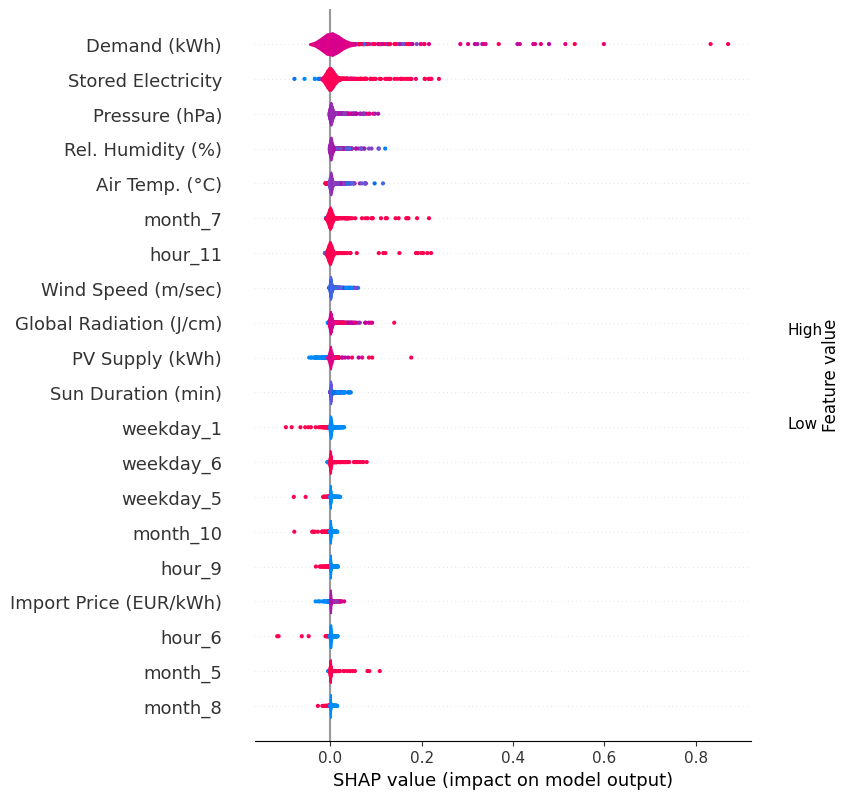

In [34]:
print_violin_plot(action_to_be_explained_index, np_shap_values, sample_df_2)

In [35]:
features_to_be_explained = ['Demand (kWh)', 'Stored Electricity', 'Pressure (hPa)', 'Rel. Humidity (%)', 'Air Temp. (°C)']

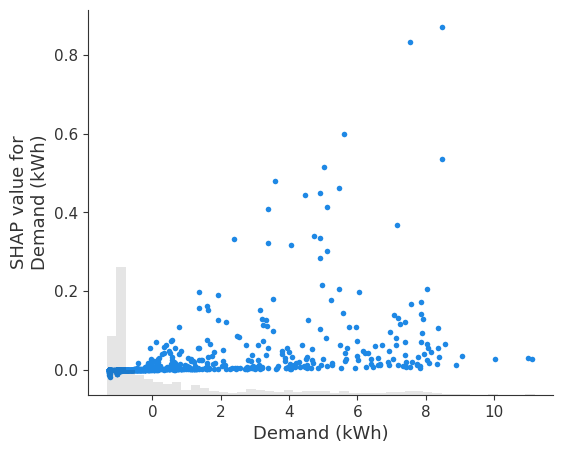

In [36]:
print_scatter_plot(action_to_be_explained_index, 0, np_shap_values, sample_df_2)

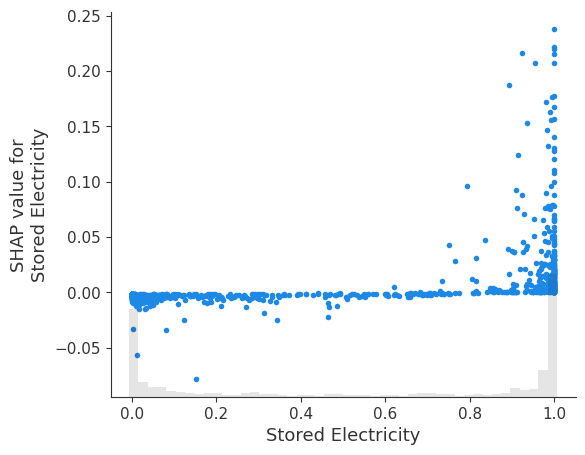

In [37]:
print_scatter_plot(action_to_be_explained_index, 1, np_shap_values, sample_df_2)

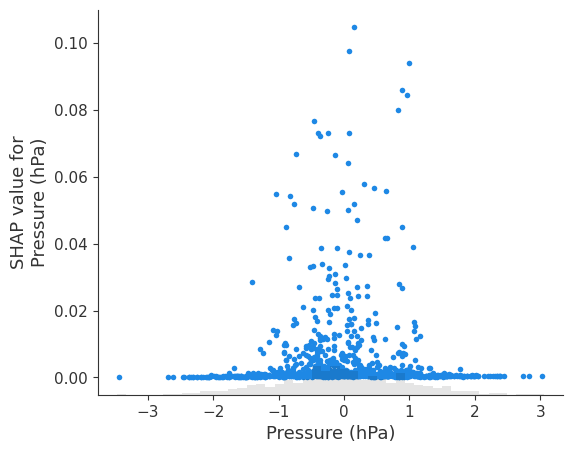

In [39]:
print_scatter_plot(action_to_be_explained_index, 2, np_shap_values, sample_df_2)

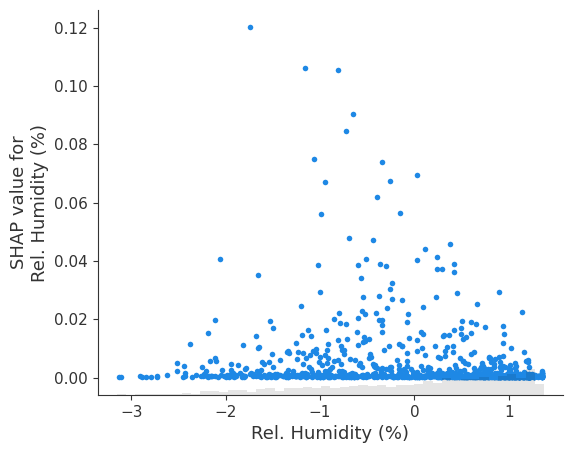

In [40]:
print_scatter_plot(action_to_be_explained_index, 3, np_shap_values, sample_df_2)

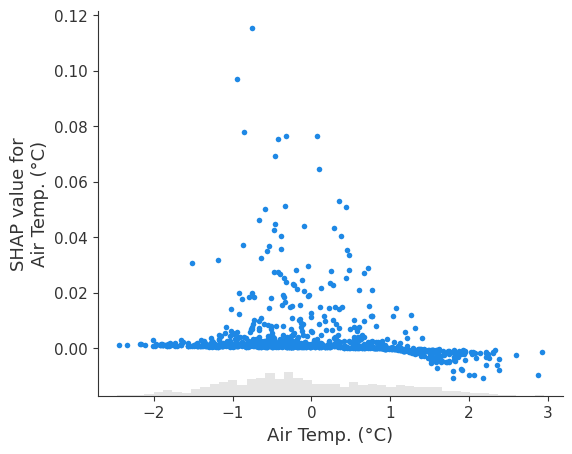

In [41]:
print_scatter_plot(action_to_be_explained_index, 4, np_shap_values, sample_df_2)

---

### Explaining Action 1: 
Higher values for this action mean, that the percentage of stored electricity used for covering the demand is higher.

Lower values for this action mean, that the percentage of stored electricity used for covering the demand is lower.

In [42]:
action_to_be_explained_index = 1

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


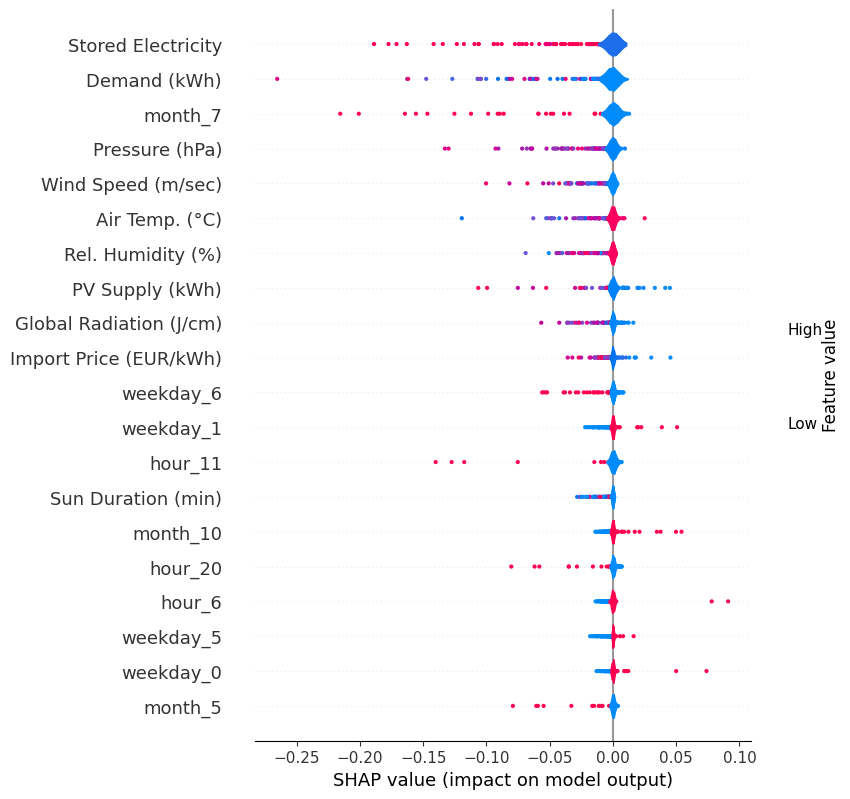

In [43]:
print_violin_plot(action_to_be_explained_index, np_shap_values, sample_df_2)

In [44]:
features_to_be_explained = ['Stored Electricity', 'Demand (kWh)', 'month_7', 'Pressure (hPa)', 'Wind Speed (m/sec)']

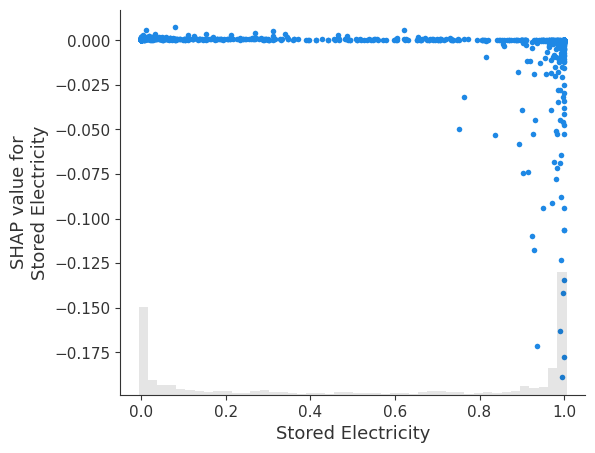

In [45]:
print_scatter_plot(action_to_be_explained_index, 0, np_shap_values, sample_df_2)

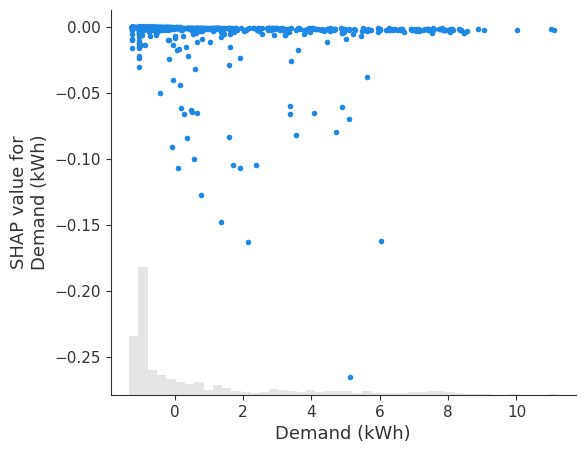

In [46]:
print_scatter_plot(action_to_be_explained_index, 1, np_shap_values, sample_df_2)

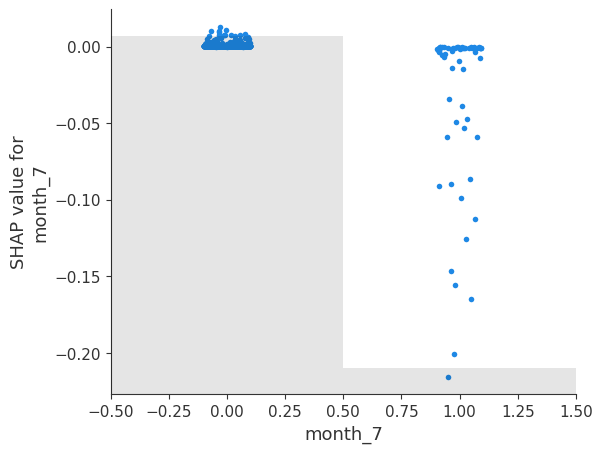

In [47]:
print_scatter_plot(action_to_be_explained_index, 2, np_shap_values, sample_df_2)

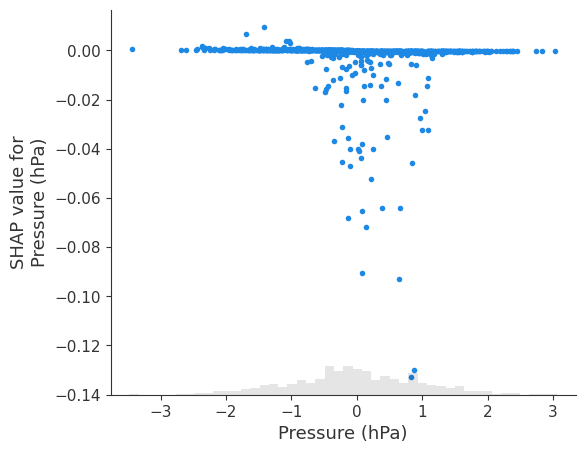

In [48]:
print_scatter_plot(action_to_be_explained_index, 3, np_shap_values, sample_df_2)

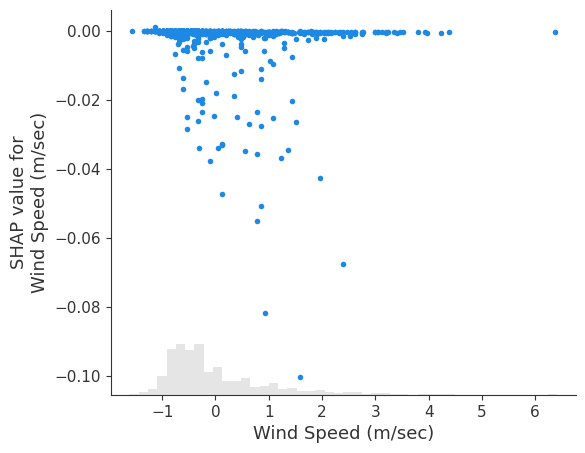

In [49]:
print_scatter_plot(action_to_be_explained_index, 4, np_shap_values, sample_df_2)

---

### Explaining Action 2: 
Higher values for this action mean, that the percentage of free storage capacity, filled via PV supply, is higher.

Lower values for this action mean, that the percentage of of free storage capacity, filled via PV supply, is lower.

In [50]:
action_to_be_explained_index = 2

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


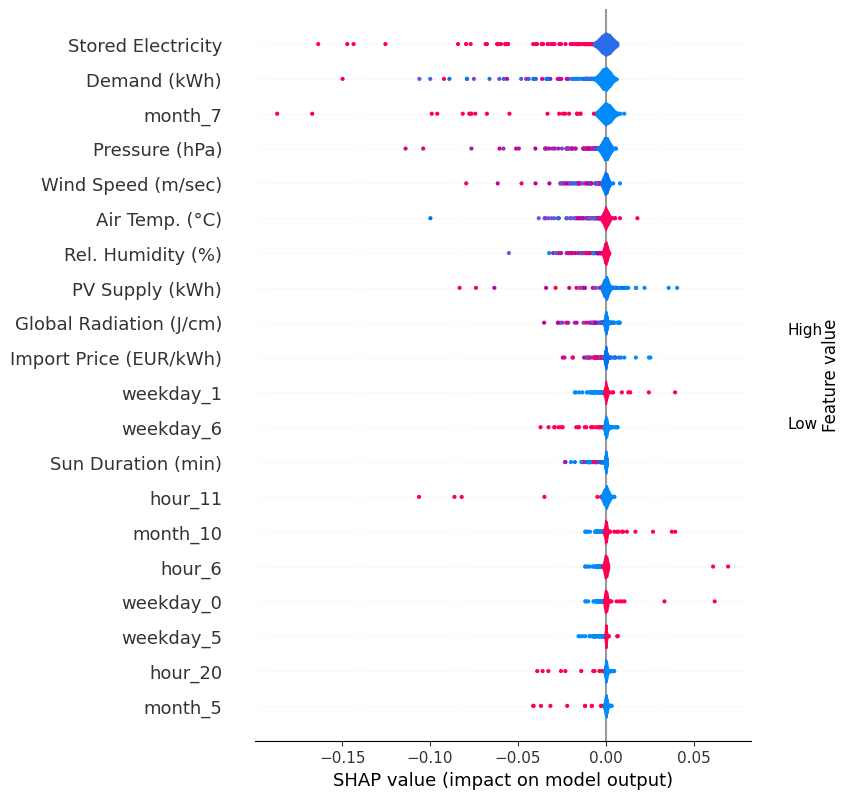

In [51]:
print_violin_plot(action_to_be_explained_index, np_shap_values, sample_df_2)

In [52]:
features_to_be_explained = ['Stored Electricity', 'Demand (kWh)', 'month_7', 'Pressure (hPa)', 'Wind Speed (m/sec)']

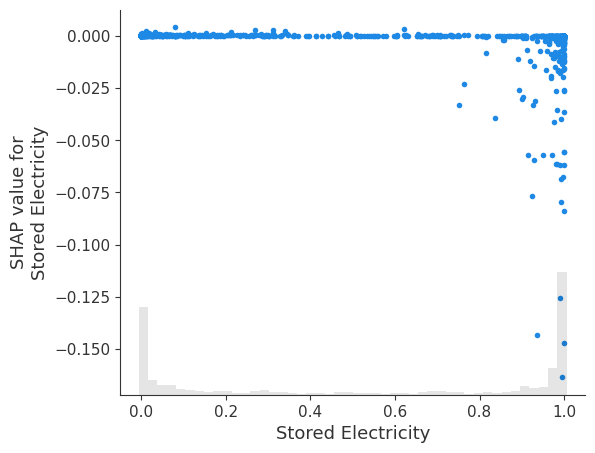

In [53]:
print_scatter_plot(action_to_be_explained_index, 0, np_shap_values, sample_df_2)

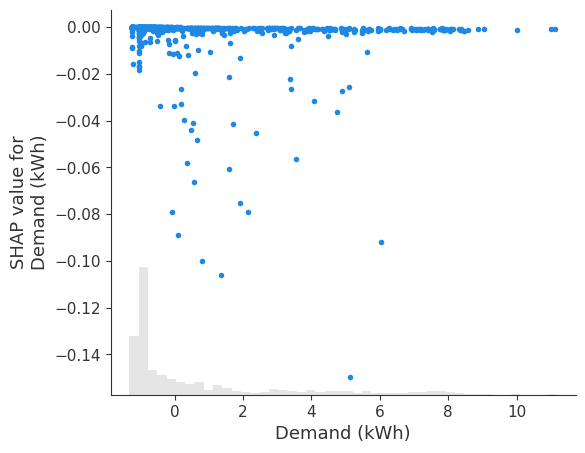

In [54]:
print_scatter_plot(action_to_be_explained_index, 1, np_shap_values, sample_df_2)

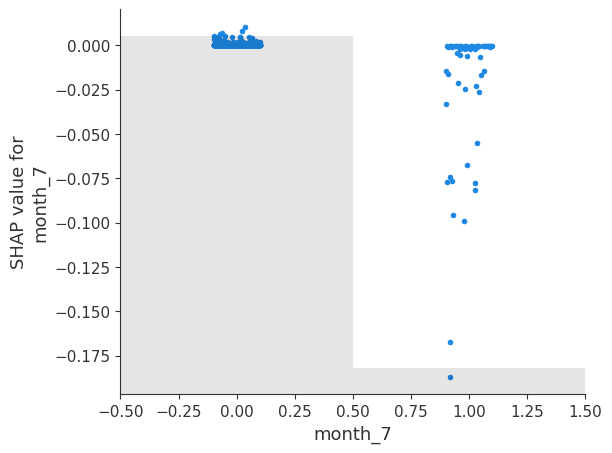

In [55]:
print_scatter_plot(action_to_be_explained_index, 2, np_shap_values, sample_df_2)

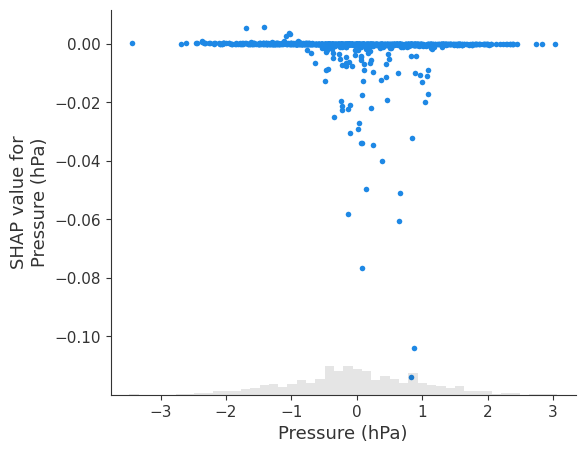

In [56]:
print_scatter_plot(action_to_be_explained_index, 3, np_shap_values, sample_df_2)

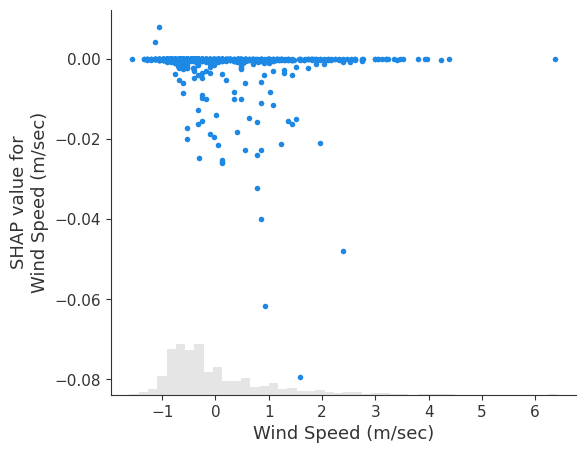

In [57]:
print_scatter_plot(action_to_be_explained_index, 4, np_shap_values, sample_df_2)

---

### Explaining Action 3: 
Higher values for this action mean, that the percentage of stored electricity sold into the grid is higher.

Lower values for this action mean, that the percentage of stored electricity sold into the grid  is lower.

In [58]:
action_to_be_explained_index = 3

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


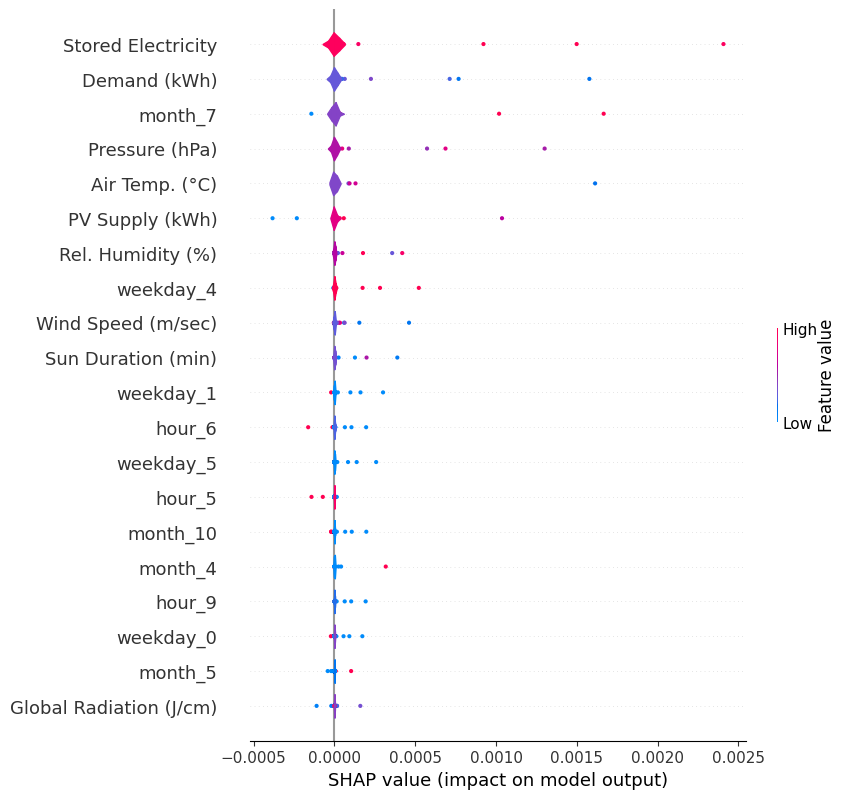

In [59]:
print_violin_plot(action_to_be_explained_index, np_shap_values, sample_df_2)

In [60]:
features_to_be_explained = ['Stored Electricity', 'Demand (kWh)', 'month_7', 'Pressure (hPa)', 'Air Temp. (°C)']

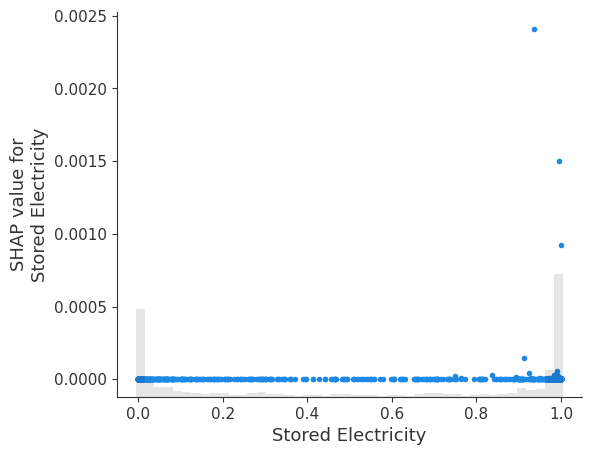

In [61]:
print_scatter_plot(action_to_be_explained_index, 0, np_shap_values, sample_df_2)

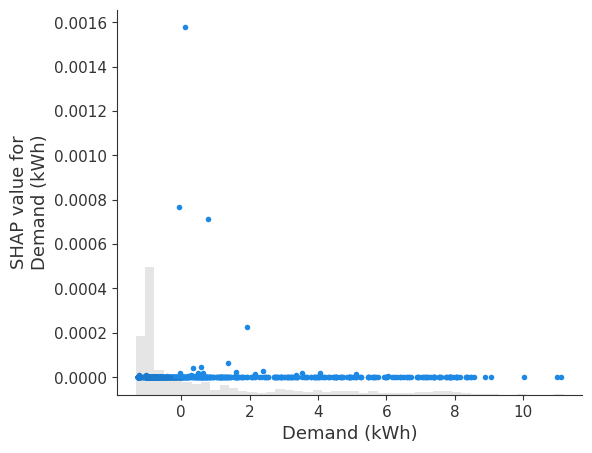

In [62]:
print_scatter_plot(action_to_be_explained_index, 1, np_shap_values, sample_df_2)

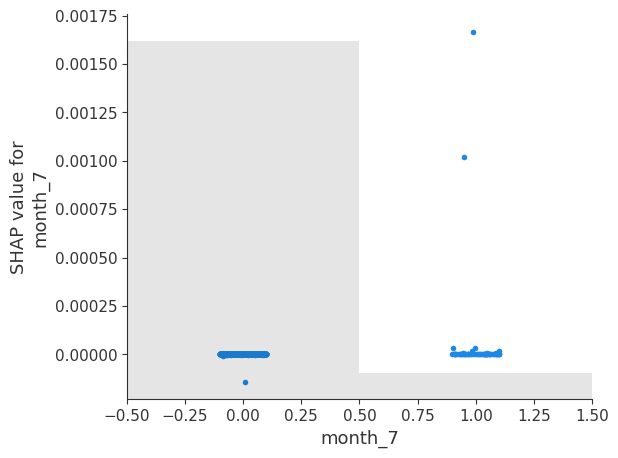

In [63]:
print_scatter_plot(action_to_be_explained_index, 2, np_shap_values, sample_df_2)

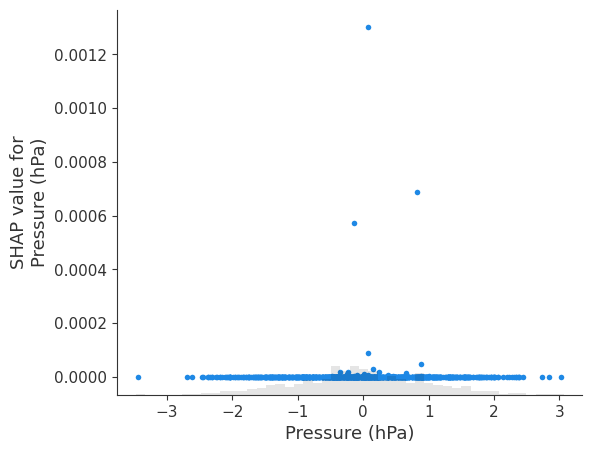

In [64]:
print_scatter_plot(action_to_be_explained_index, 3, np_shap_values, sample_df_2)

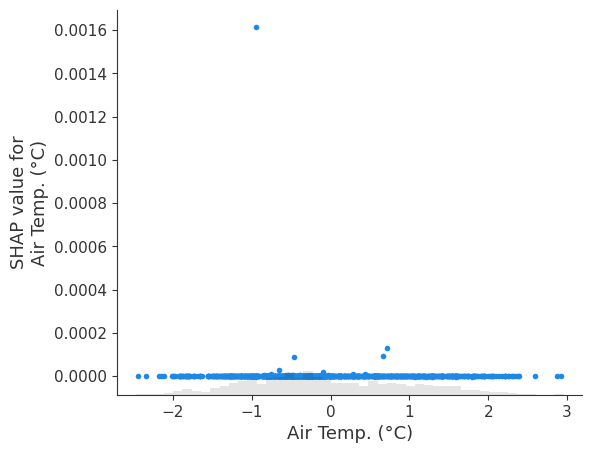

In [65]:
print_scatter_plot(action_to_be_explained_index, 4, np_shap_values, sample_df_2)

---

### Explaining Action 4: 
Higher values for this action mean, that the percentage of free storage capacity, filled via the grid, is higher.

Lower values for this action mean, that the percentage of free storage capacity, filled via the grid, is lower.

In [66]:
action_to_be_explained_index = 4

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


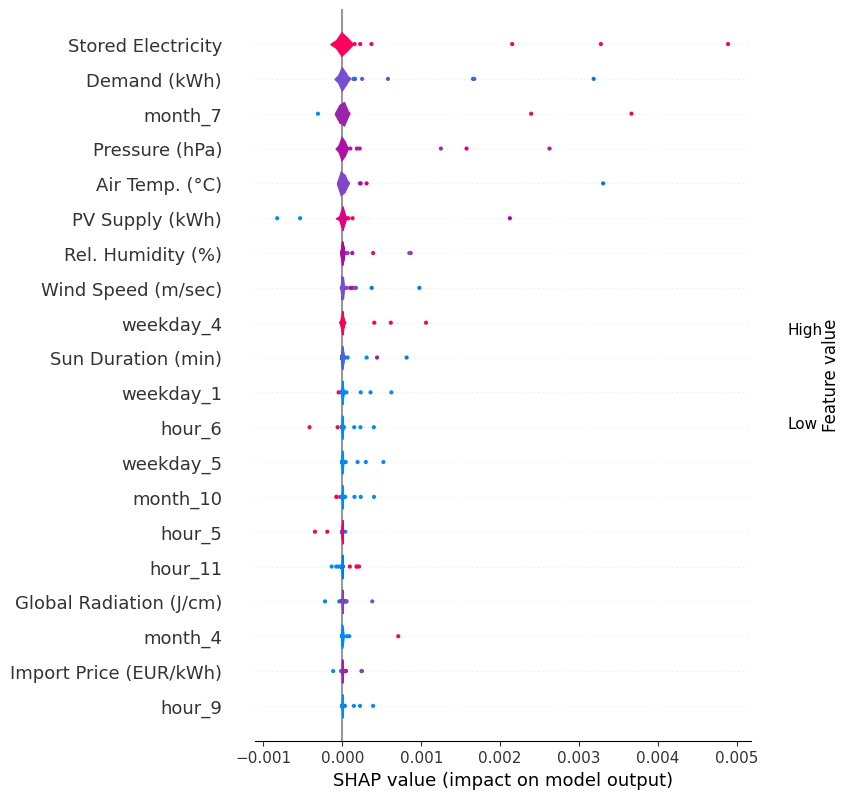

In [67]:
print_violin_plot(action_to_be_explained_index, np_shap_values, sample_df_2)

In [68]:
features_to_be_explained = ['Stored Electricity', 'Demand (kWh)', 'month_7', 'Pressure (hPa)', 'Air Temp. (°C)']

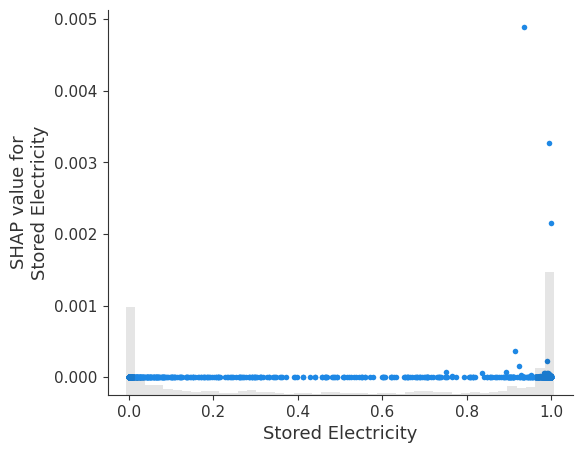

In [70]:
print_scatter_plot(action_to_be_explained_index, 0, np_shap_values, sample_df_2)

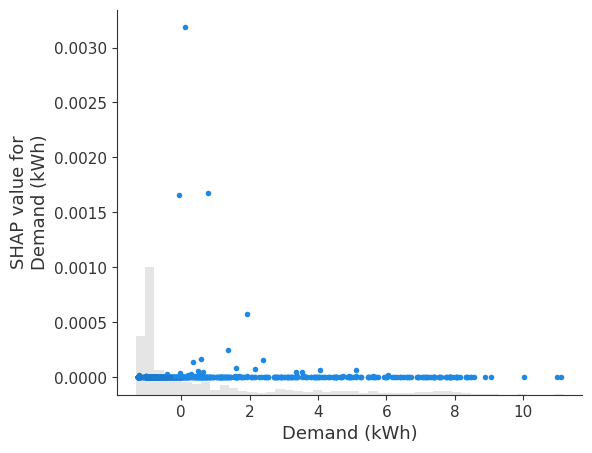

In [71]:
print_scatter_plot(action_to_be_explained_index, 1, np_shap_values, sample_df_2)

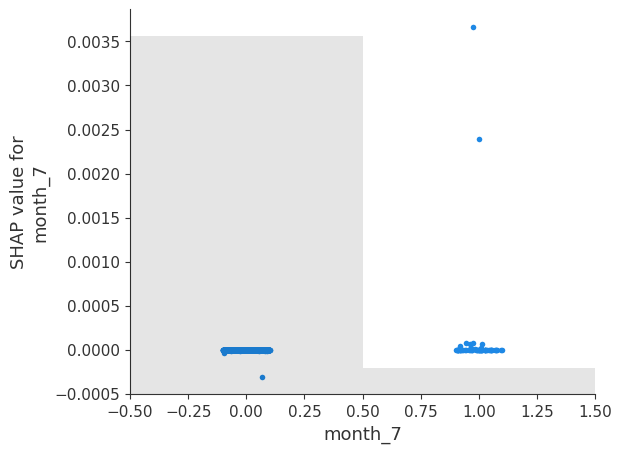

In [72]:
print_scatter_plot(action_to_be_explained_index, 2, np_shap_values, sample_df_2)

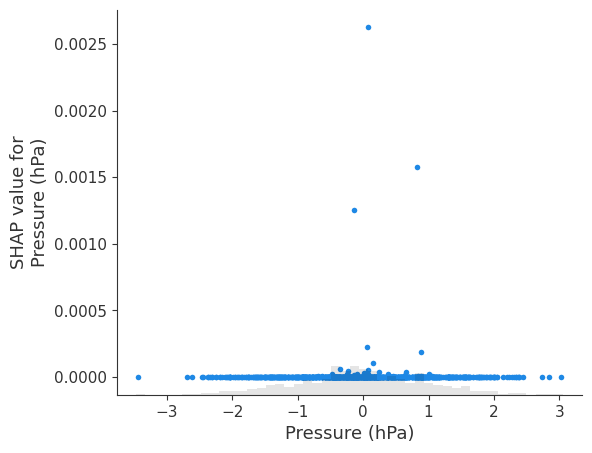

In [73]:
print_scatter_plot(action_to_be_explained_index, 3, np_shap_values, sample_df_2)

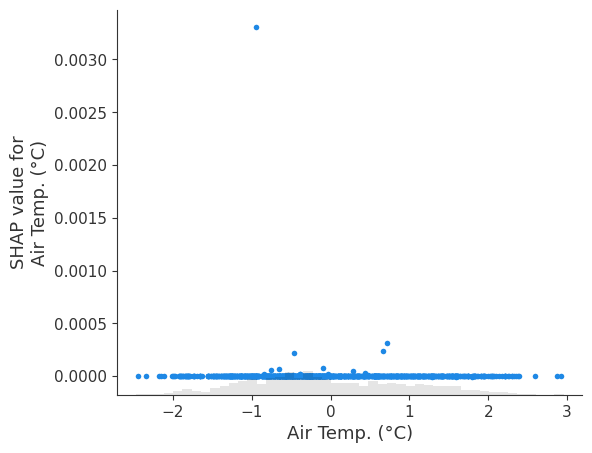

In [74]:
print_scatter_plot(action_to_be_explained_index, 4, np_shap_values, sample_df_2)